In [1]:
# DATA_PATH = '/root/Internship-Valeo/Project/data/COCO/'
DATA_PATH = '/root/Internship-Valeo/Project/data/KITTI-360/'

In [2]:
import yaml
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers as tfl
from tensorflow_addons.image import transform as H_transform
import os
from models.utils import box_nms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from models.homographies import *
from utils.tools import dict_update
from plot_utils import plot_imgs

from models.utils import shared_encoder, detector_head, detector_loss, model_metrics, box_nms

In [3]:
# train_images = os.listdir(DATA_PATH+'anntrain2014')
# val_images = os.listdir(DATA_PATH+'annval2014')
# mask_train_images = os.listdir(DATA_PATH+'anntrain2014')
# mask_val_images = os.listdir(DATA_PATH+'annval2014')

In [4]:
import yaml
with open('/root/Internship-Valeo/Project/configs/magic-point_kitti360_export.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [5]:
default_config = {
        'labels': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [240, 320]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

In [6]:
config1 = config
config = dict_update(default_config, config['data'])

In [7]:
default_model_config = {
            'data_format': 'channels_first',
            'kernel_reg': 0.,
            'grid_size': 8,
            'detection_threshold': 0.4,
            'homography_adaptation': {'num': 0},
            'nms': 0,
            'top_k': 0
    }

In [8]:
model_config = dict_update(default_model_config, config1['model'])

In [9]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
#         self.add_loss(tf.math.reduce_mean(loss))
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'precision')
        self.add_metric(metrics['recall'], name = 'recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape1, input_shape2, input_shape3):
    images_inputs = Input(shape = input_shape1, name = 'image')
    valid_masks_inputs = Input(shape = input_shape2, name = 'valid_mask')
    warped_points_inputs = Input(shape = input_shape3, name = 'keypoints')
    
    if model_config['data_format'] == 'channels_first':
        images_inputs1 = tf.transpose(images_inputs, [0, 3, 1, 2])
    
    encoder = shared_encoder(shape = (1, 240, 320), model_config = model_config)
    encoder_output = encoder(images_inputs1)
    
    detector = detector_head(shape= (128, 30, 40), model_config = model_config)
    output = detector(encoder_output)
        
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [10]:
model = net(input_shape1 = (240, 320, 1), input_shape2 = (240, 320), input_shape3 = (240, 320))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [11]:
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-120x160-synth-aug-020422')
# model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco-040422')

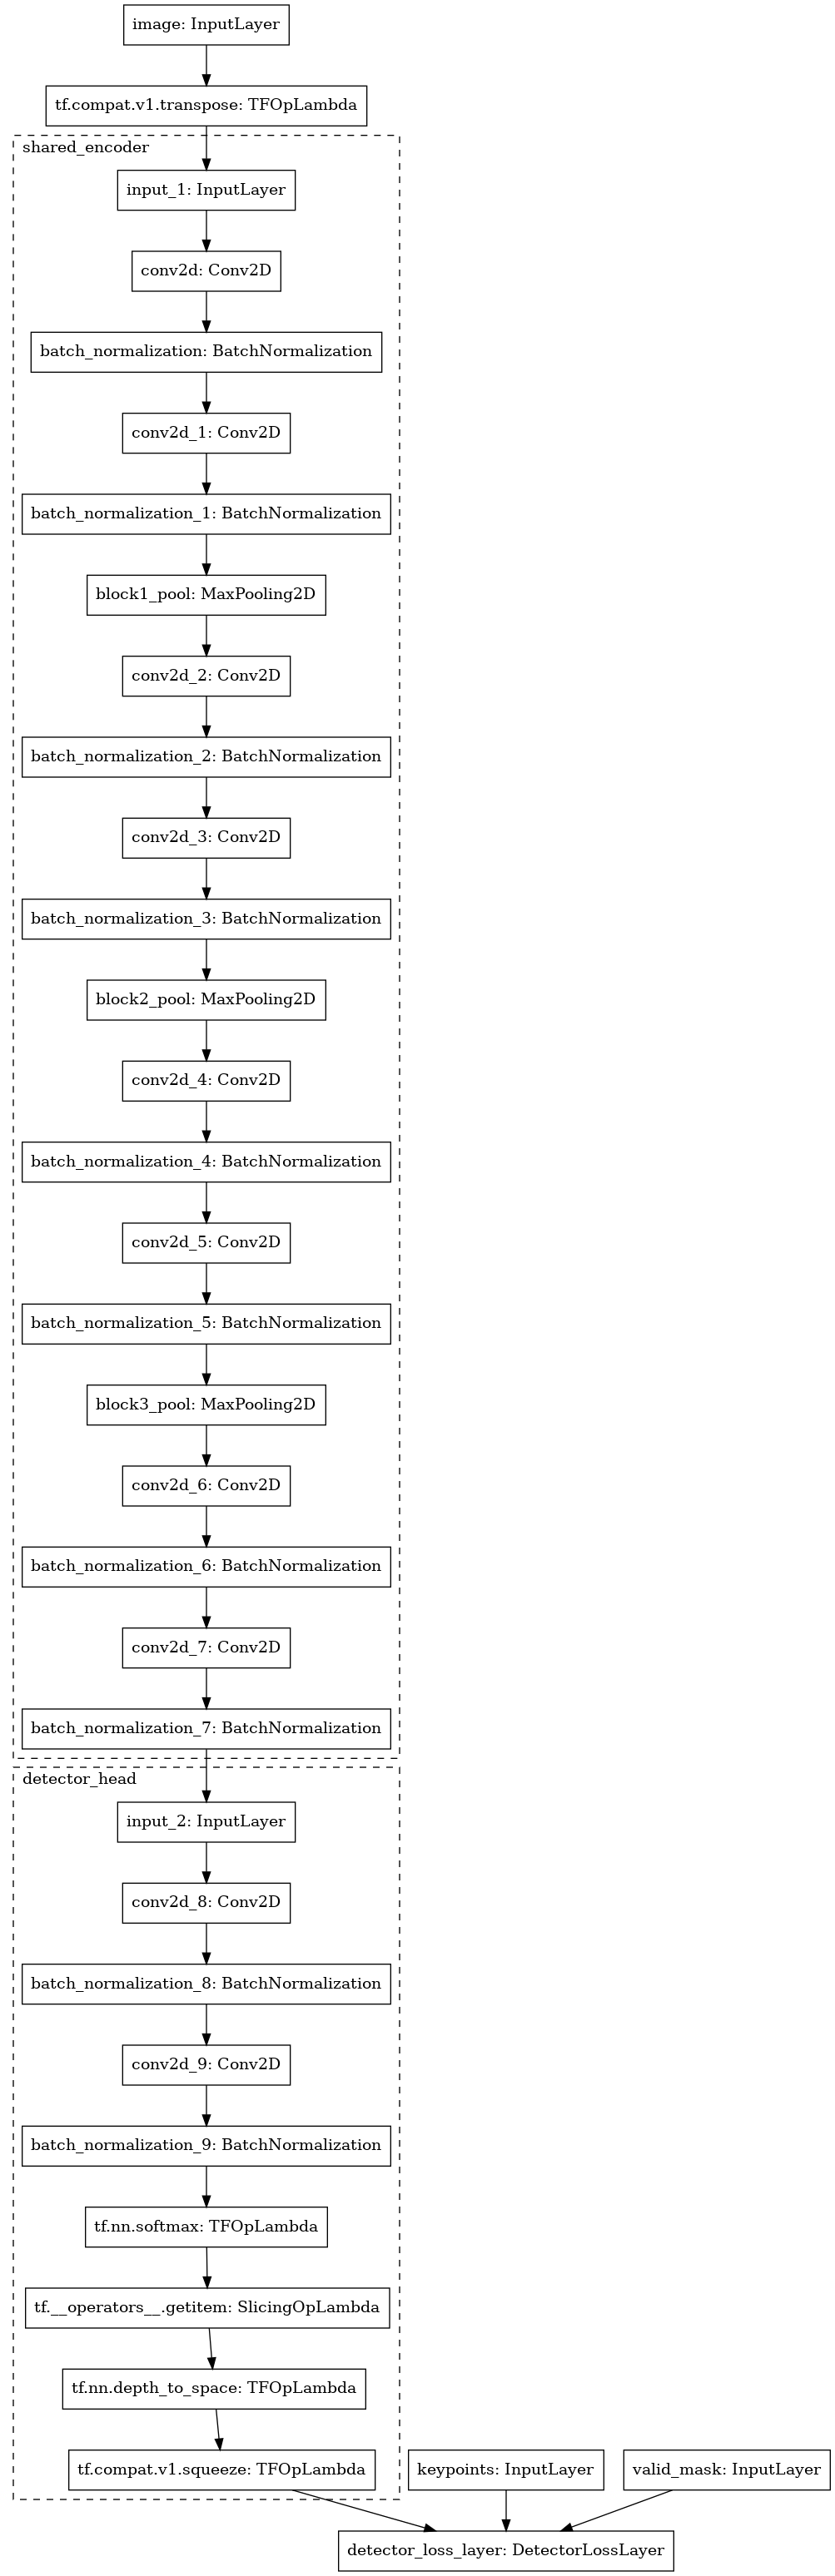

In [12]:
keras.utils.plot_model(model, rankdir="TB", expand_nested=True)

In [13]:
# from datasets import coco
# data = coco.Coco()
# files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# train_gen = train_gen.batch(5)
# val_gen = data._get_data(files, 'validation', **config)
# val_gen = val_gen.batch(5)

In [14]:
from datasets import kitti360
data = kitti360.Kitti()
files = data._init_dataset(**config)
train_gen = data._get_data(files, 'training', **config)
train_gen = train_gen.batch(5)
val_gen = data._get_data(files, 'validation', **config)
val_gen = val_gen.batch(5)

In [15]:
x = iter(train_gen)

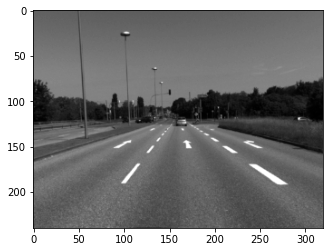

In [16]:
y = x.get_next()['image']
plt.imshow(y[0], cmap='gray')

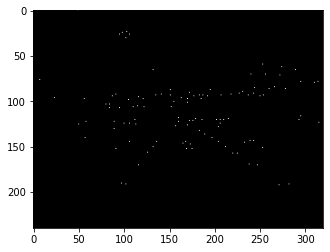

In [17]:
# prob = model.get_layer('tf.compat.v1.squeeze').output

output = model.get_layer('detector_loss_layer').input[1]
m = keras.models.Model(inputs = model.input[0], outputs = output)

y_pred = m.predict(y)

if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred['prob'])
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    
# pred = pred * tf.cast(x['valid_mask'], tf.float32) # multiplied with valid masks

plt.imshow(pred[0], cmap = 'gray')

# Homographic Adaptation

In [18]:
HA = homography_adaptation(y, m, model_config['homography_adaptation'])

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


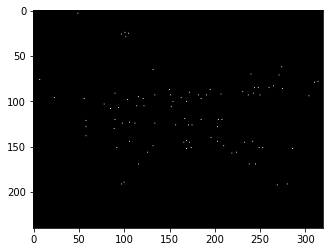

In [19]:
if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), HA['prob'])
pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.int32)
    
# pred = pred * x[1] # multiplication by valid mask commented out as it's not a warped image

plt.imshow(pred[0], cmap = 'gray')

In [20]:
def draw_keypoints(img, corners, color, s = 4):
    keypoints = [cv2.KeyPoint(c[1]*s, c[0]*s, 1) for c in np.stack(corners).T]
    img = cv2.resize(img, None, fx=s, fy=s)
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

In [21]:
# Img = np.array(data[0])
# plot_imgs([draw_keypoints(Img[..., 0], tf.cast(np.where(pred[0]), tf.float32), (0, 255, 0))/255.], dpi=300)
# plot_imgs([HA['counts'][0]>model_config['homography_adaptation']['filter_counts']], cmap='gray', dpi=300)

In [22]:
# plot_imgs([HA['input_images'][0][..., 0, i+1]/255 for i in range(5)], cmap='gray')

# Detections on train images with homographic adaptation

In [ ]:
batch_size = 5

test_set = data._get_data(files, 'testing', **config)
test_set = test_set.batch(batch_size)
x = iter(test_set)
i = 0
while True:
    dataset = x.get_next()
    # Predict
    HA = homography_adaptation(dataset['image'], m, model_config['homography_adaptation'])
    if model_config['nms']:
        prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), HA['prob'])
    p = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.int32)
    pred = {'points': [np.array(np.where(e)).T for e in p]}
    # Export
    d2l = lambda d: [dict(zip(d, e)) for e in zip(*d.values())]  # noqa: E731
    for p, d in zip(d2l(pred), d2l(dataset)):
        if not ('name' in d):
            p.update(d)  # Can't get the data back from the filename --> dump
        filename = d['name'] if 'name' in d else str(i)
        filepath = os.path.join(DATA_PATH, 'magic_point-synth-export','pointstrain2014','{}.npz'.format(filename))
#         filepath = os.path.join(DATA_PATH, 'magic_point-kitti360-export','pointstrain2014','{}.npz'.format(filename.numpy().decode('utf-8')))
        np.savez_compressed(filepath, **p)
        i += 1

# Detections on val images with homographic adaptation

# Detections on train images without homographic adaptation

In [ ]:
# Repeat when a detector has been trained again

# for file_path in train_images:
#     I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
#     I = cv2.resize(I,(320, 240))
#     I = np.expand_dims(I, axis = 0)
#     I = np.expand_dims(I, axis = 3)
#     result = model.predict(I)
    
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel
#     labels = tf.argmax(result['logits'], axis =cindex)
#     one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
#     # Strip the extra “no interest point” dustbin
#     one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
#     one_hot = tf.nn.depth_to_space(
#               one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     one_hot = tf.squeeze(one_hot, axis=cindex)
#     one_hot = np.argwhere(one_hot[0])
#     np.save(os.path.join(DATA_PATH, 'pointstrain2014',file_path), one_hot)

# Detections on val images without homographic adaptation

In [ ]:
# Repeat when a detector has been trained again

# for file_path in val_images:
#     I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
#     I = cv2.resize(I,(320, 240))
#     I = np.expand_dims(I, axis = 0)
#     I = np.expand_dims(I, axis = 3)
#     result = model.predict(I)
    
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel
#     labels = tf.argmax(result['logits'], axis =cindex)
#     one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
#     # Strip the extra “no interest point” dustbin
#     one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
#     one_hot = tf.nn.depth_to_space(
#               one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     one_hot = tf.squeeze(one_hot, axis=cindex)
#     one_hot = np.argwhere(one_hot[0])
#     np.save(os.path.join(DATA_PATH, 'pointsval2014',file_path), one_hot)

# Save homographies, warped images, warped masks, warped points

In [ ]:
# config = {
#             'add_augmentation_to_test_set': False,
#             'num_parallel_calls': 10,
#             'preprocessing': {
#                 'resize': [240, 320],
#                 'blur_size': 11,
#             },
#             'augmentation': {
#                 'photometric': {
#                     'enable': True,
#                     'primitives': 'all',
#                     'params': {
#                         'random_brightness': {'max_abs_change': 75},
#                         'random_contrast': {'strength_range': [0.3, 1.8]},
#                         'additive_gaussian_noise': {'stddev_range': [0, 15]},
#                         'additive_speckle_noise': {'prob_range': [0, 0.0035]},
#                         'additive_shade':{
#                             'transparency_range': [-0.5, 0.8],
#                             'kernel_size_range': [50, 100]},
#                         'motion_blur': {'max_kernel_size': 7}},
#                     'random_order': True,
#                 },
#                 'homographic': {
#                     'enable': True,
#                     'params': {
#                         'translation': True,
#                         'rotation': True,
#                         'scaling': True,
#                         'perspective': True,
#                         'scaling_amplitude': 0.2,
#                         'perspective_amplitude_x': 0.2,
#                         'perspective_amplitude_y': 0.2,
#                         'patch_ratio': 0.8,
#                         'max_angle': 1.57,  # 3.14
#                         'allow_artifacts': True,
#                         'translation_overflow': 0.05,
#                         'valid_border_margin': 3,
#                     },
#                 },
#             }
#     }

In [ ]:
# image_shape = (240, 320)

In [ ]:
# for file_path in train_images:
#     # read image
#     I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
#     # resize image
#     I = cv2.resize(I,(320, 240))
#     # add homography
#     homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
#     path = os.path.join(DATA_PATH, 'homographies_train', file_path)
#     np.save(path, homography)
#     # generate warped_image and save
#     warped_image = H_transform(I, homography, interpolation='BILINEAR')
#     cv2.imwrite(os.path.join(DATA_PATH, 'warptrain2014',file_path), np.array(warped_image))
#     # read mask
#     M = cv2.imread(os.path.join(DATA_PATH, 'masktrain2014',file_path),0)
#     # warp mask 
#     warped_mask_image = H_transform(M, homography, interpolation='NEAREST')
#     cv2.imwrite(os.path.join(DATA_PATH, 'warp_mask_train2014',file_path), np.array(warped_mask_image))
#     # compute valid mask
#     valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['augmentation']['homographic']['params']['valid_border_margin'])
#     # read key points map
#     points = np.load(os.path.join(DATA_PATH, 'pointstrain2014',file_path+'.npy'))
#     warped_points = warp_points(points, homography)
# #     warped_points = tf.minimum(warped_points, tf.cast(image_shape, tf.float32)-1)
# #     warped_points = np.round(warped_points).astype(int)
#     # save warped interest points
#     np.save(os.path.join(DATA_PATH, 'warped_pointstrain2014',file_path), warped_points)

In [ ]:
# for file_path in val_images:
#     # read image
#     I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
#     # resize image
#     I = cv2.resize(I,(320, 240))
#     # add homography
#     homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
#     path = os.path.join(DATA_PATH, 'homographies_val', file_path)
#     np.save(path, homography)
#     # generate warped_image and save
#     warped_image = H_transform(I, homography, interpolation='BILINEAR')
#     cv2.imwrite(os.path.join(DATA_PATH, 'warpval2014',file_path), np.array(warped_image))
#     # read mask
#     M = cv2.imread(os.path.join(DATA_PATH, 'maskval2014',file_path),0)
#     # warp mask 
#     warped_mask_image = H_transform(M, homography, interpolation='NEAREST')
#     cv2.imwrite(os.path.join(DATA_PATH, 'warp_mask_val2014',file_path), np.array(warped_mask_image))
#     # compute valid mask
#     valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['augmentation']['homographic']['params']['valid_border_margin'])
#     # read key points map
#     points = np.load(os.path.join(DATA_PATH, 'pointsval2014',file_path+'.npy'))
#     warped_points = warp_points(points, homography)
# #     warped_points = tf.minimum(warped_points, tf.cast(image_shape, tf.float32)-1)
# #     warped_points = np.round(warped_points).astype(int)
#     # save warped interest points
#     np.save(os.path.join(DATA_PATH, 'warped_pointsval2014',file_path), warped_points)